In [1]:
pip install pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset
data = pd.read_csv('data.csv')

# 1. **Data Preprocessing**

# Convert the 'date' column to datetime format if not already
data['date'] = pd.to_datetime(data['date'])

# Extract relevant features from the 'date' column
data['day_of_week'] = data['date'].dt.dayofweek  # 0=Monday, 6=Sunday
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['day'] = data['date'].dt.day

# Drop the original 'date' column
data = data.drop(columns=['date'])

# Now the datetime data has been converted into numerical features


# 2. **Feature Encoding**

# Label encode categorical variables (e.g., specialization, gender)
categorical_columns = ['specialization', 'time_slot', 'patient_gender', 'day_of_week', 'availability_status']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store the encoder for later use

# 3. **Handle Multi-label Columns**

# MultiLabelBinarizer for multi-label columns
mlb_doctors = MultiLabelBinarizer()
mlb_time_slots = MultiLabelBinarizer()

# Transform alternative_doctors and alternative_time_slots columns
data['alternative_doctors'] = data['alternative_doctors'].apply(lambda x: eval(x) if isinstance(x, str) else x)
data['alternative_time_slots'] = data['alternative_time_slots'].apply(lambda x: eval(x) if isinstance(x, str) else x)

alternative_doctors_encoded = mlb_doctors.fit_transform(data['alternative_doctors'])
alternative_time_slots_encoded = mlb_time_slots.fit_transform(data['alternative_time_slots'])

# Add these transformed columns to the dataframe
alternative_doctors_columns = [f'alter_doctor_{i}' for i in range(alternative_doctors_encoded.shape[1])]
alternative_time_slots_columns = [f'alter_time_slot_{i}' for i in range(alternative_time_slots_encoded.shape[1])]

data[alternative_doctors_columns] = alternative_doctors_encoded
data[alternative_time_slots_columns] = alternative_time_slots_encoded

# Drop the original multi-label columns
data = data.drop(columns=['alternative_doctors', 'alternative_time_slots'])

# 4. **Prepare the Final Feature and Target Variables**
X = data[['specialization', 'time_slot', 'patient_age', 'patient_gender', 'day_of_week', 'is_holiday'] + alternative_doctors_columns + alternative_time_slots_columns]
y = data[['recommended_doctor', 'recommended_time_slot', 'peak_demand_alert']]

# 5. **Feature Scaling**
scaler = StandardScaler()

# Fit the scaler to the training data and then transform it
X_train[['patient_age']] = scaler.fit_transform(X_train[['patient_age']])
X_test[['patient_age']] = scaler.transform(X_test[['patient_age']])


# 6. **Check Data Types for Target Columns**
# Ensure that the target columns are encoded correctly as categorical or numerical
# Use LabelEncoder to convert string columns like 'recommended_doctor' and 'recommended_time_slot' to integers
label_encoder_doctor = LabelEncoder()
label_encoder_time_slot = LabelEncoder()

y['recommended_doctor'] = label_encoder_doctor.fit_transform(y['recommended_doctor'])
y['recommended_time_slot'] = label_encoder_time_slot.fit_transform(y['recommended_time_slot'])

# Convert 'peak_demand_alert' to binary (0 or 1)
y['peak_demand_alert'] = y['peak_demand_alert'].map({'Yes': 1, 'No': 0})  # Binary encoding for peak_demand_alert

# 7. **Train-Test Split**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. **Model Training**

# Using RandomForestClassifier for multi-output prediction
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Wrap the classifier in MultiOutputClassifier to handle multiple outputs
multi_output_rf = MultiOutputClassifier(rf, n_jobs=-1)

# Train the model
multi_output_rf.fit(X_train, y_train)

# 9. **Model Evaluation**

# Evaluate model on test data
y_pred = multi_output_rf.predict(X_test)

for idx, column in enumerate(y_test.columns):
    print(f"Classification Report for {column}:")
    print(classification_report(y_test.iloc[:, idx], y_pred[:, idx], target_names=[f"Class {i}" for i in range(len(np.unique(y.iloc[:, idx])))]))

# Calculate accuracy for each target column
for idx, column in enumerate(y_test.columns):
    accuracy = accuracy_score(y_test[column], y_pred[:, idx])
    print(f"Accuracy for {column}: {accuracy:.2f}")

# Alternatively, you can calculate average accuracy
accuracies = [accuracy_score(y_test.iloc[:, idx], y_pred[:, idx]) for idx in range(y_test.shape[1])]
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.2f}")

# Overall accuracy of the model (can be computed for each target)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Overall Model Accuracy: {accuracy:.2f}")

# Detailed Classification Report
# print("Classification Report for all targets:")
# print(classification_report(y_test, y_pred))

# 10. **Making Predictions**
def predict_appointment(input_data):
    # Convert input data to match the trained model's input format
    input_df = pd.DataFrame(input_data, index=[0])
    
    # Apply encoding to categorical input features
    for col, le in label_encoders.items():
        if col in input_df:
            input_df[col] = le.transform(input_df[col])
    
    # Ensure all necessary columns (like alternative_doctors and alternative_time_slots) are present
    for col in alternative_doctors_columns + alternative_time_slots_columns:
        if col not in input_df:
            input_df[col] = 0  # Default to 0 if a column is missing
    
    # Feature Scaling
    input_df[['patient_age']] = scaler.transform(input_df[['patient_age']])
    
    # Check the shape of the input data
    print(f"Input Data Shape: {input_df.shape}")

    # Make predictions
    prediction = multi_output_rf.predict(input_df)

    # Debug: Check the shape of the prediction output
    print(f"Prediction Shape: {prediction.shape}")
    
    # Decode the predictions (if needed)
    recommended_doctor = label_encoder_doctor.inverse_transform([prediction[0][0]])[0]
    recommended_time_slot = label_encoder_time_slot.inverse_transform([prediction[0][1]])[0]
    peak_demand_alert = prediction[0][2]
    
    # Multi-label predictions (for alternative doctors and time slots)
    alternative_doctors = mlb_doctors.inverse_transform(prediction[:, 3:3+len(alternative_doctors_columns)])
    alternative_time_slots = mlb_time_slots.inverse_transform(prediction[:, 3+len(alternative_doctors_columns):])
    
    return {
        'recommended_doctor': recommended_doctor,
        'recommended_time_slot': recommended_time_slot,
        'alternative_doctors': alternative_doctors[0],  # Flatten the list
        'alternative_time_slots': alternative_time_slots[0],  # Flatten the list
        'peak_demand_alert': peak_demand_alert
    }

Classification Report for recommended_doctor:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        12
     Class 1       1.00      1.00      1.00        14
     Class 2       1.00      1.00      1.00        12
     Class 3       1.00      1.00      1.00         9
     Class 4       1.00      1.00      1.00        17
     Class 5       1.00      1.00      1.00        13
     Class 6       1.00      1.00      1.00        14
     Class 7       1.00      1.00      1.00        14
     Class 8       1.00      1.00      1.00        17
     Class 9       1.00      1.00      1.00        19
    Class 10       1.00      1.00      1.00         9
    Class 11       1.00      1.00      1.00        11
    Class 12       1.00      1.00      1.00        12
    Class 13       1.00      1.00      1.00        11
    Class 14       1.00      1.00      1.00        16

    accuracy                           1.00       200
   macro avg       1.00      1.00 

In [97]:
import joblib

# Save the trained model
joblib.dump(model, 'healthcare_appointment_model.pkl')

['healthcare_appointment_model.pkl']

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

# Initialize label encoders for categorical columns
specialization_encoder = LabelEncoder()
time_slot_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
doctor_encoder = LabelEncoder()
time_slot_encoder = LabelEncoder()

# Example data (replace this with your actual data)
X = data[['specialization', 'time_slot', 'patient_age', 'patient_gender', 'day_of_week', 'is_holiday', 'month', 'year', 'day']]  # Features
y = data[['recommended_doctor', 'recommended_time_slot', 'peak_demand_alert']]  # Target columns

# Encode categorical columns
X['specialization'] = specialization_encoder.fit_transform(X['specialization'])
X['time_slot'] = time_slot_encoder.fit_transform(X['time_slot'])
X['patient_gender'] = gender_encoder.fit_transform(X['patient_gender'])

y['recommended_doctor'] = doctor_encoder.fit_transform(y['recommended_doctor'])
y['recommended_time_slot'] = time_slot_encoder.fit_transform(y['recommended_time_slot'])
y['peak_demand_alert'] = y['peak_demand_alert'].map({'Yes': 1, 'No': 0})  # If it's a binary categorical column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model (RandomForestClassifier)
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# After training the model, save it
joblib.dump(model, 'healthcare_appointment_model.pkl')

# Also save the label encoders
joblib.dump(specialization_encoder, 'specialization_encoder.pkl')
joblib.dump(time_slot_encoder, 'time_slot_encoder.pkl')
joblib.dump(gender_encoder, 'gender_encoder.pkl')
joblib.dump(doctor_encoder, 'doctor_encoder.pkl')

print("Model and encoders saved successfully!")

Model and encoders saved successfully!


In [103]:
print(data.columns)

Index(['specialization', 'time_slot', 'patient_age', 'patient_gender',
       'doctor_id', 'availability_status', 'booking_status', 'is_peak_demand',
       'day_of_week', 'is_holiday', 'recommended_doctor',
       'recommended_time_slot', 'peak_demand_alert', 'month', 'year', 'day',
       'alter_doctor_0', 'alter_doctor_1', 'alter_doctor_2', 'alter_doctor_3',
       'alter_doctor_4', 'alter_doctor_5', 'alter_doctor_6', 'alter_doctor_7',
       'alter_doctor_8', 'alter_doctor_9', 'alter_doctor_10',
       'alter_doctor_11', 'alter_doctor_12', 'alter_doctor_13',
       'alter_doctor_14', 'alter_time_slot_0', 'alter_time_slot_1',
       'alter_time_slot_2'],
      dtype='object')


In [112]:
import pandas as pd
import joblib

# Load the trained model and encoders
loaded_model = joblib.load('healthcare_appointment_model.pkl')
specialization_encoder = joblib.load('specialization_encoder.pkl')
time_slot_encoder = joblib.load('time_slot_encoder.pkl')
gender_encoder = joblib.load('gender_encoder.pkl')
doctor_encoder = joblib.load('doctor_encoder.pkl')

# Example input data (replace with actual input)
input_data = {
    'specialization': 'Cardiology',  # Example value
    'time_slot': 'Morning',          # Example value
    'patient_age': 45,               # Example value
    'patient_gender': 'Male',        # Example value
    'day_of_week': 3,                # Example value
    'is_holiday': 0,                 # Example value
    'month': 2,                      # Example value
    'year': 2025,                    # Example value
    'day': 15                        # Example value
}

# Convert the input data to a format suitable for prediction
input_features = [
    specialization_encoder.transform([input_data['specialization']])[0] if input_data['specialization'] in specialization_encoder.classes_ else -1,
    time_slot_encoder.transform([input_data['time_slot']])[0] if input_data['time_slot'] in time_slot_encoder.classes_ else -1,
    input_data['patient_age'],
    gender_encoder.transform([input_data['patient_gender']])[0] if input_data['patient_gender'] in gender_encoder.classes_ else -1,
    input_data['day_of_week'],
    input_data['is_holiday'],
    input_data['month'],
    input_data['year'],
    input_data['day']
]

# Create a DataFrame with the correct column names
input_df = pd.DataFrame([input_features], columns=[
    'specialization', 'time_slot', 'patient_age', 'patient_gender', 
    'day_of_week', 'is_holiday', 'month', 'year', 'day'
])

# Make a prediction using the model
prediction = loaded_model.predict(input_df)

# Decode the prediction
recommended_doctor = doctor_encoder.inverse_transform([prediction[0][0]])[0]
recommended_time_slot = time_slot_encoder.inverse_transform([prediction[0][1]])[0]
peak_demand_alert = 'Yes' if prediction[0][2] == 1 else 'No'

# Output the prediction
print(f"Recommended Doctor: {recommended_doctor}")
print(f"Recommended Time Slot: {recommended_time_slot}")
print(f"Peak Demand Alert: {peak_demand_alert}")

Recommended Doctor: 102
Recommended Time Slot: Morning
Peak Demand Alert: Yes


In [19]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


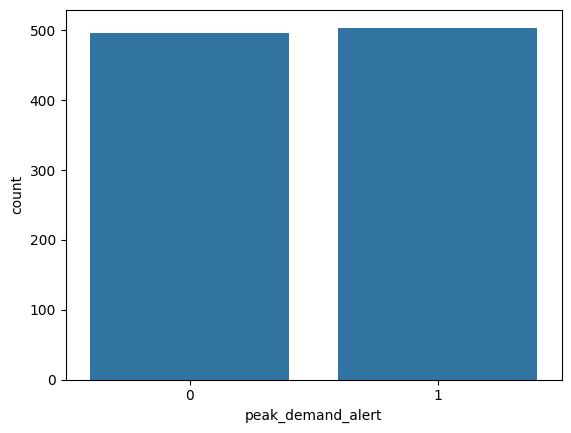

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check distribution of 'peak_demand_alert'
sns.countplot(x='peak_demand_alert', data=y)
plt.show()

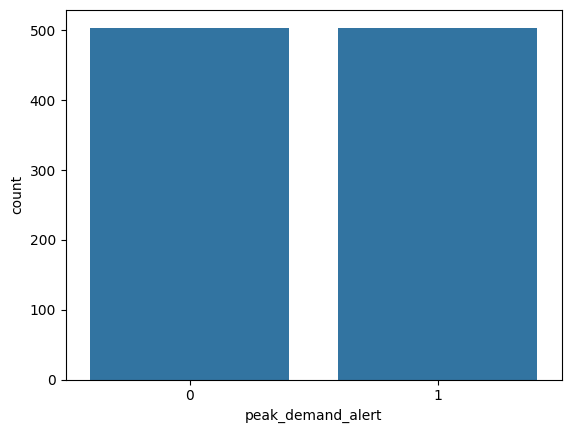

In [21]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y['peak_demand_alert'])

# Check the new class distribution
sns.countplot(x=y_res)
plt.show()

In [22]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_res, y_res)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Fit the model with the best parameters
rf_best = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


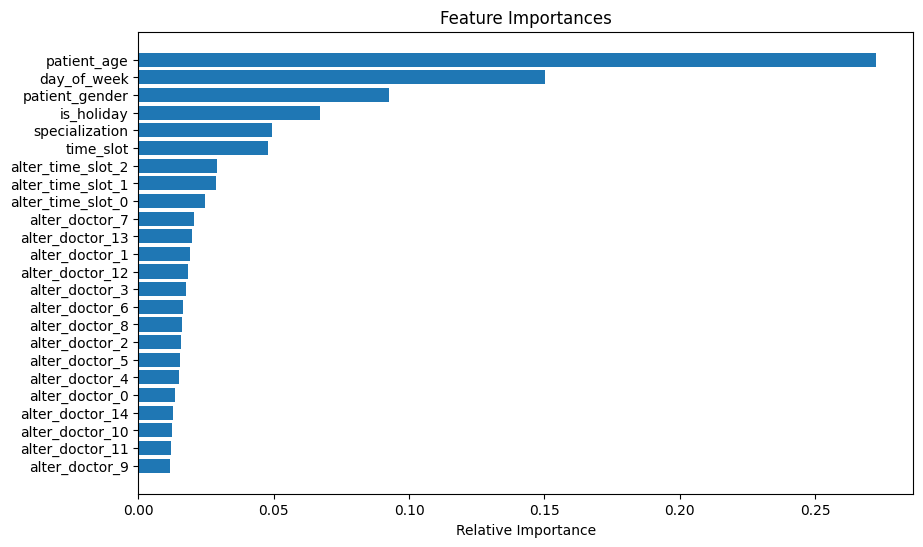

In [23]:
# Get feature importance
importances = rf_best.feature_importances_
indices = importances.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel("Relative Importance")
plt.show()

In [24]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_best, X_res, y_res, cv=5, scoring='accuracy')

# Print the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")

Cross-validation scores: [0.54455446 0.55445545 0.59405941 0.52238806 0.53233831]
Mean CV score: 0.5495591350179795


In [27]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to both X and y for consistent resampling
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y_peak_demand)  # Resample both X and y

# Now split the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Fit the RandomForest model on the 'peak_demand_alert' target
rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

# Classification report and accuracy
from sklearn.metrics import classification_report, accuracy_score

print("Classification Report for peak_demand_alert:")
print(classification_report(y_test, y_pred))
print(f"Accuracy for peak_demand_alert: {accuracy_score(y_test, y_pred)}")

Classification Report for peak_demand_alert:
              precision    recall  f1-score   support

           0       0.48      0.66      0.55        90
           1       0.60      0.42      0.49       112

    accuracy                           0.52       202
   macro avg       0.54      0.54      0.52       202
weighted avg       0.55      0.52      0.52       202

Accuracy for peak_demand_alert: 0.5247524752475248


In [28]:
print(X_res.shape)
print(y_res.shape)

(1008, 24)
(1008,)


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Train the RandomForest model with class weights
rf_best = RandomForestClassifier(n_estimators=200, max_depth=20, 
                                 min_samples_split=10, min_samples_leaf=4, 
                                 class_weight='balanced', random_state=42)

rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

print("Classification Report for peak_demand_alert:")
print(classification_report(y_test, y_pred))
print(f"Accuracy for peak_demand_alert: {accuracy_score(y_test, y_pred)}")

Classification Report for peak_demand_alert:
              precision    recall  f1-score   support

           0       0.46      0.61      0.53        90
           1       0.58      0.43      0.49       112

    accuracy                           0.51       202
   macro avg       0.52      0.52      0.51       202
weighted avg       0.53      0.51      0.51       202

Accuracy for peak_demand_alert: 0.5099009900990099


In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_rf_model.predict(X_test)
print("Classification Report for peak_demand_alert:")
print(classification_report(y_test, y_pred))
print(f"Accuracy for peak_demand_alert: {accuracy_score(y_test, y_pred)}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Classification Report for peak_demand_alert:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        90
           1       0.56      0.46      0.50       112

    accuracy                           0.50       202
   macro avg       0.51      0.51      0.50       202
weighted avg       0.51      0.50      0.50       202

Accuracy for peak_demand_alert: 0.5


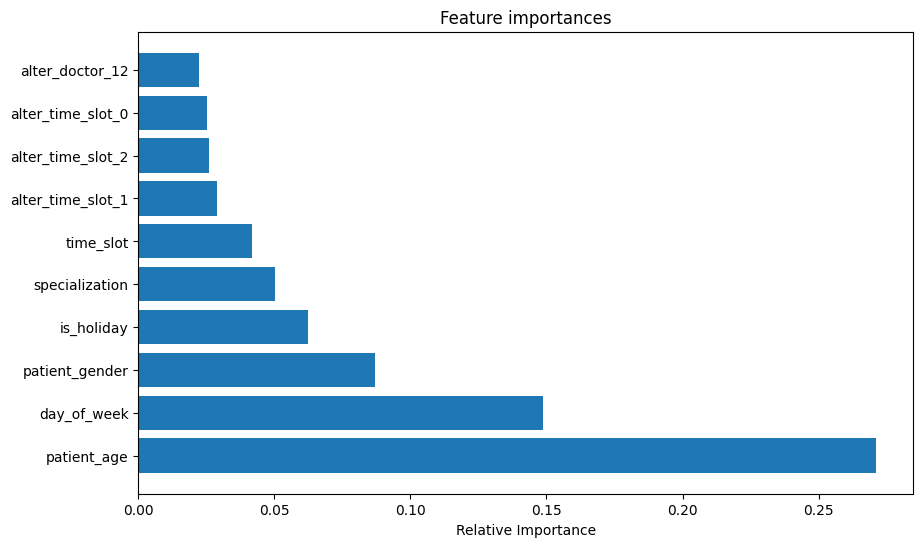

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance from the trained model
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh(range(10), importances[indices[:10]], align="center")
plt.yticks(range(10), [X_train.columns[i] for i in indices[:10]])
plt.xlabel("Relative Importance")
plt.show()

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model on the resampled data
rf_best.fit(X_resampled, y_resampled)
y_pred = rf_best.predict(X_test)

# Evaluate the model again
print("Classification Report for peak_demand_alert:")
print(classification_report(y_test, y_pred))
print(f"Accuracy for peak_demand_alert: {accuracy_score(y_test, y_pred)}")

Classification Report for peak_demand_alert:
              precision    recall  f1-score   support

           0       0.49      0.64      0.56        90
           1       0.61      0.46      0.52       112

    accuracy                           0.54       202
   macro avg       0.55      0.55      0.54       202
weighted avg       0.56      0.54      0.54       202

Accuracy for peak_demand_alert: 0.5396039603960396


In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model on the resampled data
rf_best.fit(X_resampled, y_resampled)
y_pred = rf_best.predict(X_test)

# Evaluate the model again
print("Classification Report for peak_demand_alert:")
print(classification_report(y_test, y_pred))
print(f"Accuracy for peak_demand_alert: {accuracy_score(y_test, y_pred)}")

Classification Report for peak_demand_alert:
              precision    recall  f1-score   support

           0       0.49      0.64      0.56        90
           1       0.61      0.46      0.52       112

    accuracy                           0.54       202
   macro avg       0.55      0.55      0.54       202
weighted avg       0.56      0.54      0.54       202

Accuracy for peak_demand_alert: 0.5396039603960396


In [45]:
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],  # Further reduce depth to avoid overfitting
    'min_samples_split': [5, 10],  # Increase to prevent overfitting
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']  # Use 'sqrt' instead of 'auto'
}

In [46]:
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, random_state=42, error_score='raise')
random_search.fit(X_resampled, y_resampled)

d:\Resume\one drive\OneDrive\Desktop\ml_others\env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   random_state=42)

In [47]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15],  # Further reduce depth to avoid overfitting
    'min_samples_split': [5, 10],  # Increase to prevent overfitting
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']  # Use 'sqrt' instead of 'auto'
}

# Perform RandomizedSearchCV with the adjusted grid
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=5, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters:", random_search.best_params_)

# Evaluate the model on the test set
y_pred = random_search.predict(X_test)

# Classification report for the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Accuracy score
accuracy = random_search.score(X_test, y_test)
print(f"Accuracy for peak_demand_alert: {accuracy}")

d:\Resume\one drive\OneDrive\Desktop\ml_others\env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
              precision    recall  f1-score   support

           0       0.45      0.62      0.52        90
           1       0.56      0.38      0.46       112

    accuracy                           0.49       202
   macro avg       0.50      0.50      0.49       202
weighted avg       0.51      0.49      0.48       202

Accuracy for peak_demand_alert: 0.4900990099009901


In [48]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define SMOTE and RandomForest pipeline
smote = SMOTE(sampling_strategy='auto', random_state=42)
model = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=15)

# Create a pipeline with SMOTE followed by RandomForest
pipeline = Pipeline(steps=[('smote', smote), ('model', model)])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)

# Classification report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.60      0.53        90
           1       0.59      0.46      0.51       112

    accuracy                           0.52       202
   macro avg       0.53      0.53      0.52       202
weighted avg       0.53      0.52      0.52       202

Accuracy: 0.5198019801980198


In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

import pandas as pd

# Load your dataset (replace with the correct path to your CSV file)
df = pd.read_csv('data.csv')

# Split your data into features and target
X = df.drop('peak_demand_alert', axis=1)
y = df['peak_demand_alert']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

# Print classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

ValueError: could not convert string to float: 'Orthopedics'

In [68]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load your dataset
df = pd.read_csv('data.csv')  # Update with your file path

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns that need encoding
categorical_columns = ['specialization', 'patient_gender', 'time_slot', 'availability_status']  # Add any other categorical columns here

# Encode all categorical columns
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Convert 'date' to datetime type
df['date'] = pd.to_datetime(df['date'])

# Extract useful parts of the date (e.g., year, month, day, hour)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.weekday  # Monday=0, Sunday=6

# Drop the original 'date' column as it's no longer needed
df.drop('date', axis=1, inplace=True)

# Handle NaN values: fill with the median for numerical columns and the most frequent value for categorical columns
df = df.apply(lambda col: col.fillna(col.median()) if col.dtype != 'object' else col.fillna(col.mode()[0]))

# Check if there are any NaN values after handling
print("\nNaN values in X before applying SMOTE:")
print(df.isna().sum())

# Split your data into features (X) and target (y)
X = df.drop('peak_demand_alert', axis=1)
y = df['peak_demand_alert']

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Check the shape of X and y before and after dropping rows with NaN
print(f"Shape of X before dropping NaN: {X.shape}")
print(f"Shape of y before dropping NaN: {y.shape}")

# Explicitly drop NaNs and make sure to adjust y accordingly
X = X.dropna()
y = y[X.index]  # Keep the same indices in y after dropping NaNs in X

print(f"Shape of X after dropping NaN: {X.shape}")
print(f"Shape of y after dropping NaN: {y.shape}")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Function to make a prediction on new inputs
def predict_peak_demand_alert(new_data):
    # Preprocessing new data (same encoding as the original data)
    for col in categorical_columns:
        new_data[col] = label_encoder.transform([new_data[col]])
    
    # Convert 'date' in new data to datetime and extract features
    new_data['date'] = pd.to_datetime(new_data['date'])
    new_data['year'] = new_data['date'].dt.year
    new_data['month'] = new_data['date'].dt.month
    new_data['day'] = new_data['date'].dt.day
    new_data['hour'] = new_data['date'].dt.hour
    new_data['weekday'] = new_data['date'].dt.weekday
    new_data.drop('date', axis=1, inplace=True)  # Drop 'date' column
    
    # Ensure the new data is numeric
    new_data = new_data.apply(pd.to_numeric, errors='coerce')
    
    # Predict the peak demand alert using the trained model
    prediction = rf_classifier.predict([new_data])[0]
    
    # Return the prediction result
    if prediction == 0:
        return "No Peak Demand"
    else:
        return "Peak Demand"

# Example input to check prediction
new_data = {
    'specialization': 'Orthopedics',  # Example value, replace with actual input
    'patient_age': 35,                # Example value, replace with actual input
    'patient_gender': 'Male',         # Example value, replace with actual input
    'time_slot': 'Morning',           # Example value, replace with actual input
    'availability_status': 'Available',  # Example value, replace with actual input
    'date': '2025-02-01 10:30:00'     # Example value, replace with actual input
}

# Convert the new input to a DataFrame
new_data_df = pd.DataFrame([new_data])

# Make a prediction
result = predict_peak_demand_alert(new_data_df.iloc[0])
print("Prediction for peak demand alert:", result)


NaN values in X before applying SMOTE:
specialization            0
time_slot                 0
patient_age               0
patient_gender            0
doctor_id                 0
availability_status       0
booking_status            0
is_peak_demand            0
day_of_week               0
is_holiday                0
recommended_doctor        0
recommended_time_slot     0
alternative_doctors       0
alternative_time_slots    0
peak_demand_alert         0
year                      0
month                     0
day                       0
hour                      0
weekday                   0
dtype: int64
Shape of X before dropping NaN: (1000, 19)
Shape of y before dropping NaN: (1000,)
Shape of X after dropping NaN: (0, 19)
Shape of y after dropping NaN: (0,)


ValueError: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required by SMOTE.

In [69]:
# Check for NaN values in y
print(f"NaN values in y: {y.isna().sum()}")

# Drop rows with NaN values from X and y
X = X.dropna()
y = y[X.index]  # Keep the corresponding y values

print(f"Shape of X after dropping NaN: {X.shape}")
print(f"Shape of y after dropping NaN: {y.shape}")

# If there are still NaNs, handle them
if X.shape[0] == 0 or y.shape[0] == 0:
    print("Warning: No data available after removing rows with NaN values!")
else:
    # Apply SMOTE if there are enough data samples
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

    # Initialize Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

    # Train the model
    rf_classifier.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_classifier.predict(X_test)
    print(classification_report(y_test, y_pred))

NaN values in y: 0
Shape of X after dropping NaN: (0, 19)
Shape of y after dropping NaN: (0,)
